In [1]:
import numpy as np
import glob, os, string, import_ipynb, copy
from keras import layers as ly
from keras.models import Sequential, load_model, Model
from keras.layers import Input, Lambda, LSTM, Dense, RepeatVector, TimeDistributed
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from scipy.spatial.distance import cosine as cosine_distance
from keras.models import model_from_json
from collections import Counter
import drawingGraph as G
import warnings
import random as rd
warnings.filterwarnings("ignore", category=UserWarning)

Using TensorFlow backend.


importing Jupyter notebook from drawingGraph.ipynb


In [2]:
'''def getIndexFromGraph(filename):
    index = int(filename.split('-')[0].replace('graph', ''))
    return index
'''
def getIndexFromGraph(filename):
    index, idx = map(int, (filename.split('_')))
    return index, idx

In [3]:
def calculateGraphGroup(num_dict):
    for index, data in enumerate(all_data):
        idx, loc = getIndexFromGraph(graph_group[index])
        num_dict[idx-1][loc-1] += 1
    return num_dict

In [4]:
def getEmbeddingSum():
    sum_embedding = [[[0 for i in range(embedded_length)] for i in range(per_groups[i])] for i in range(group_count)]
    for index, data in enumerate(all_data):
        data = data.reshape(1, data.shape[0], data.shape[1])
        embedded = encoder.predict(data)
        idx, loc = getIndexFromGraph(graph_group[index])
        sum_embedding[idx-1][loc-1] += embedded.reshape(embedded.shape[1])
    return sum_embedding

In [5]:
def getEmbeddingAvg():
    avg_embedding = [[[0 for i in range(embedded_length)] for i in range(per_groups[i])] for i in range(group_count)]
    #avg_embedding = [[0 for i in range(embedded_length)] for i in range(graph_length)]
    sum_embedding = getEmbeddingSum()
    for i in range(len(all_data)):
        idx, loc = getIndexFromGraph(graph_group[i])
        avg_embedding[idx-1][loc-1] = sum_embedding[idx-1][loc-1] / num_dict[idx-1][loc-1]
    return avg_embedding

In [6]:
def getMode(values):
    values.sort()
    mode = Counter(values).most_common()
    maximum = mode[0][1]
    if maximum == 1:
        return values.mean()
    else:
        dt = []
        for m in mode:
            if maximum == m[1]:
                dt.append(m[0])
            else:
                break
        return np.array(dt).mean()

In [7]:
def getEmbeddingVector(group_num, index):
    data_index = []
    data = []
    counts = num_dict[group_num][index]
    
    for num, i in enumerate(graph_group):
        idx, loc = getIndexFromGraph(i)
        if idx == group_num + 1 and loc == index + 1:
            data_index.append(num)
        if len(data_index) == counts:
            break
    
    for i in data_index:
        dt = all_data[i].reshape(1, all_data[i].shape[0], all_data[i].shape[1])
        dt = encoder.predict(dt)
        dt = dt.reshape(dt.shape[1])
        data.append(dt)
    return data

In [8]:
def getEmbeddingMode(): # 최빈값
    mode_embedding = [[[0 for i in range(embedded_length)] for i in range(per_groups[i])] for i in range(group_count)]
    for i in range(group_count):
        for index in range(per_groups[i]):
            vectors = np.array(getEmbeddingVector(i, index))
            tmp = [0 for i in range(embedded_length)]
            for count in range(embedded_length):
                values = vectors[:, count].reshape(num_dict[i][index])
                tmp[count] = getMode(values)
            mode_embedding[i][index] = tmp
    return mode_embedding

In [9]:
def getEmbeddingExceptMinMax():
    except_embedding = [[[0 for i in range(embedded_length)] for i in range(per_groups[i])] for i in range(group_count)]

    for i in range(group_count):
        for index in range(per_groups[i]):
            vectors = np.array(getEmbeddingVector(i, index))
            tmp = [0 for i in range(embedded_length)]
            for count in range(embedded_length):
                values = vectors[:, count].reshape(num_dict[i][index])
                values.sort()
                tmp[count] = values[1:-1].mean()
            except_embedding[i][index] = tmp
    return except_embedding

In [10]:
def euclidean_distance(a, b):
    a = np.array(a)
    b = np.array(b)
    return np.sqrt(np.sum(a-b) ** 2)

In [11]:
def getDistFromEmbedding(distance_measure, embedding, obj):
    if embedding  == 'sum':
        embeddings = sum_embedding
    elif embedding == 'avg':
        embeddings = avg_embedding
    elif embedding == 'mode':
        embeddings = mode_embedding
    elif embedding =='except':
        embeddings = except_embedding
    
    dist = []
    for i in range(group_count):
        for index in range(per_groups[i]):
            if distance_measure == 'euc':
                dist.append(eucliean_distance(obj, embeddings[i][index]))
            else:
                dist.append(cosine_distance(obj, embeddings[i][index]))
    return dist

In [12]:
def getTopData(n, datasets, names):
    data = []
    for i in names[:n+1]:
        data.append(datasets[i])
    return data

In [13]:
def draw(drawobj, drawobj_name, dir_name, save):
    for index, obj in enumerate(drawobj):
        G.drawGraph(dir_name, 'graph' + str(drawobj_name[index]+1), index, obj, save)

In [296]:
filename = 'cce_model' #input('filename: ')
json_file = open("models/original/cce_model.json", "r") #"+filename+"
loaded_model_json = json_file.read() 
lstm_autoencoder = model_from_json(loaded_model_json)
lstm_autoencoder.load_weights('models/original/weights_'+ filename + '.h5')

In [297]:
alpha = list(string.ascii_uppercase)
chr2index = {alpha[i]:i+1 for i in range(len(alpha))}

In [298]:
def chr2OH(alphabet):
    oh = [0 for i in range(len(alpha))]
    index = chr2index[alphabet]-1
    oh[index] = 1
    return oh

In [299]:
data = [['A', 'B', 13.8], ['A', 'C', 5.1], ['A', 'D', 4.3],['A', 'E', 5.8761],['B', 'F', 18.7],['B', 'G', 23.6802],['B', 'H', 15.4],['F', 'I', 12.1],['F', 'J', 7.2222],['F', 'K', 4.8]]
chr2OH('A')

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [300]:
dir = './datasets/group/*'

graph_group = []
chr_data = []
all_data = []
sequence_length = []
alpha = list(string.ascii_uppercase)
data_length = len(glob.glob(dir))
file_predix = './datasets/seq/group'

for index in range(1, data_length+1):
    filename = file_predix + str(index) + "/*"
    print(filename)
    count = 0
    files = sorted(glob.glob(filename))
    for file in files:
        datasets = []
        chr_dts = []
        graph_group.append(file.split('/')[-1].replace('.txt', '').split('-')[0].replace('graph', '_'))
        for rf in open(file, 'r'):
            (u, v, w) = rf[1:-2].split(', ')
            chr_dts.append([u[1], v[1], w])
            #datasets.append(chr2OH(u[1]) + chr2OH(v[1]) +[float(w)])
            datasets.append([chr2index[u[1]], chr2index[v[1]], float(w)])
        sequence_length.append(len(datasets))
        all_data.append(datasets)
        chr_data.append(chr_dts)
all_data = np.array([np.array(arr) for arr in all_data])

./datasets/seq/group1/*
./datasets/seq/group2/*
./datasets/seq/group3/*
./datasets/seq/group4/*
./datasets/seq/group5/*
./datasets/seq/group6/*


In [301]:
graph_length =600#1080 #1260#len(glob.glob('./latest_graph_data/*')) 
embedded_length = 64
group_count = 6
per_groups = [100, 100, 100, 100, 100, 100]

In [302]:
encoder = Model(lstm_autoencoder.input, lstm_autoencoder.layers[2].output)

In [303]:
num_dict = { i:{j:0 for j in range(per_groups[i])} for i in range(group_count)}
num_dict = calculateGraphGroup(num_dict)

In [304]:
sum_embedding = getEmbeddingSum()

In [305]:
avg_embedding = getEmbeddingAvg()

In [306]:
mode_embedding = getEmbeddingMode()

In [307]:
except_embedding = getEmbeddingExceptMinMax()

In [308]:
def getIndexes(index):
    index_range = [0, 100, 200, 300, 400, 500, 600]
    m = index;
    for j in range(1,len(index_range)+1):
        if m<index_range[j]:
            x =  j-1
            y = m-index_range[j-1]
            break
    return x, y

In [309]:
def getGraphOrder(dist):
    ordered = copy.deepcopy(dist)
    ordered.sort()
    
    names = []
    check = [[0 for i in range(per_groups[i])] for i in range(group_count)]
    
    for item in ordered:
        for index, d in enumerate(dist):
            x, y = getIndexes(index)
            if item == d and not check[x][y]:
                names.append(index)#+1)
                check[x][y] = 1
                break
    return names, ordered

In [310]:
def calcuPrecision(arr, ans):
    cnt = 0
    for a in arr:
        x, y = getIndexes(a)
        
        if ans==x:
            cnt = cnt+1
    return cnt

In [ ]:
index_range = [0, 100, 200, 300, 400, 500, 600]
ch = [0 for i in range(sum(per_groups))] # 720
mode_precision = 0
avg_precision = 0
except_precision = 0
top = 31
for t in range(11, 52, 10):
    if t==41:
        continue
    print('t : ', t)
    avg_precision = mode_precision = except_precision = 0
    for i in range(0, 6):
        if i == 5:
            print("*********************", i, )
        for idx in range(10):
            n = rd.randint(index_range[i], index_range[i+1]-1)
            while ch[n] == 1:
                n = rd.randint(index_range[i], index_range[i+1]-1)#n = rd.randint(i-210, i-1)
            ch[n] = 1

            x, y = getIndexes(n)
            avg_obj = avg_embedding[x][y]
            mode_obj = mode_embedding[x][y]
            except_obj = except_embedding[x][y]

            dist_avg_cos = getDistFromEmbedding('cos', 'avg', avg_obj)
            dist_mode_cos = getDistFromEmbedding('cos', 'mode', mode_obj)
            dist_except_cos = getDistFromEmbedding('cos', 'except', except_obj)
            names_avg_cos, ordered_avg_cos = getGraphOrder(dist_avg_cos)
            names_mode_cos, ordered_mode_cos = getGraphOrder(dist_mode_cos)
            names_except_cos, ordered_except_cos = getGraphOrder(dist_except_cos)
            #print(names_except_cos)
            #for index in names_except_cos:
            #    x, _ = getIndexes(index)0.8733333
            #    print(x, index, end=' ')
            avg_precision += calcuPrecision(names_avg_cos[1:t], x)
            #print( calcuPrecision(names_avg_cos[1:top], x), end=' ')
            mode_precision += calcuPrecision(names_mode_cos[1:t], x)
            #print(calcuPrecision(names_mode_cos[1:top], x), end=' ')
            except_precision += calcuPrecision(names_except_cos[1:t], x)
            #print(calcuPrecision(names_except_cos[1:top], x))
            #print(n, names_avg_cos[1:top], names_mode_cos[1:top], names_except_cos[1:top])
    print(avg_precision / (60*(t-1)),mode_precision / (60*(t-1)), except_precision / (60*(t-1)))

t :  11
********************* 5
1.0 0.995 1.0
t :  21


In [161]:
if top == 11:
    print( avg_precision/600, mode_precision/600, except_precision/600)
elif top == 21:
    print( avg_precision/1200, mode_precision/1200, except_precision/1200)
elif top == 31:
    print( avg_precision/1800, mode_precision/1800, except_precision/1800)
elif top == 51:
    print( avg_precision/3000, mode_precision/3000, except_precision/3000)

1.6427777777777777 1.6394444444444445 1.64


In [40]:
    print( avg_precision, mode_precision, except_precision)

597 591 599


In [43]:
#그래프 그리기 위해 각 그래프 그룹 가운데 하나씩 가져옴. (모든 노드에 대한 sequence 에서 하나의 노드 시퀀스만 가져오기) 
datasets = [[] for i in range(graph_length)]
for n, data in zip(graph_group, chr_data):
    i, j = map(int, n.split('_'))
    index = 100 * (i-1) + j -1
    if len(datasets[index]) == 0:
        d = []
        for row in data:
            #u, v, w = row
            d.append(row)
        datasets[index] = d

In [64]:
mode_obj = mode_embedding[0][0]
sum_obj = sum_embedding[0][0]
avg_obj = avg_embedding[0][0]
except_obj = except_embedding[0][0]

In [65]:
dist_avg_cos = getDistFromEmbedding('cos', 'avg', avg_obj)
names_avg_cos, ordered_avg_cos = getGraphOrder(dist_avg_cos)

dist_sum_cos = getDistFromEmbedding('cos', 'sum', sum_obj)
names_sum_cos, ordered_sum_cos = getGraphOrder(dist_sum_cos)

dist_mode_cos = getDistFromEmbedding('cos', 'mode', mode_obj)
names_mode_cos, ordered_mode_cos = getGraphOrder(dist_mode_cos)

dist_except_cos = getDistFromEmbedding('cos', 'except', except_obj)
names_except_cos, ordered_except_cos = getGraphOrder(dist_except_cos)

In [66]:
top10_mode_cos = getTopData(10, datasets, names_mode_cos)
back10_mode_cos = getTopData(10, datasets, names_mode_cos[::-1])

top10_sum_cos = getTopData(10, datasets, names_sum_cos)
back10_sum_cos = getTopData(10, datasets, names_sum_cos[::-1])

top10_avg_cos = getTopData(10, datasets, names_avg_cos)
back10_avg_cos = getTopData(10, datasets, names_avg_cos[::-1])

top10_except_cos = getTopData(10, datasets, names_except_cos)
back10_except_cos = getTopData(10, datasets, names_except_cos[::-1])

In [68]:
# check top n results
count = 0
print('      {:8s}{:8s}{:8s}{:s}'.format('sum',  'avg', 'mode','except(min, max)'))
for s, a, m, e in zip(names_sum_cos, names_avg_cos, names_mode_cos, names_except_cos):
#for s, a, m, e in zip(names_sum_cos[::-1], names_avg_cos[::-1], names_mode_cos[::-1], names_except_cos[::-1]):    
    #if s == 526 or a == 526 or m == 526 or e == 526:
    #    print(count)
    print(count, ' {:8d}{:8d}{:8d}{:8d}'.format(s+1, a+1, m+1, e+1))
    count += 1
    if count >= 21:
        break
count = 0
print('    {:8s}{:8s}{:8s}{:s}'.format('sum',  'avg', 'mode','except(min, max)'))
#for s, a, m, e in zip(names_sum_cos, names_avg_cos, names_mode_cos, names_except_cos):
for s, a, m, e in zip(names_sum_cos[::-1], names_avg_cos[::-1], names_mode_cos[::-1], names_except_cos[::-1]):    
    #if s == 526 or a == 526 or m == 526 or e == 526:
    #    print(count)
    print('{:8d}{:8d}{:8d}{:8d}'.format(s+1, a+1, m+1, e+1))
    count += 1
    if count > 21:
        break
        

      sum     avg     mode    except(min, max)
0         1       1       1       1
1        27      27      27      27
2        20      20      24      20
3        53      53      76      25
4        25      25      20      53
5        73      73      20      73
6         7       7      14       7
7         2       2      14      76
8        76      76      68      17
9        17      17      53      22
10        30      30      21      30
11        22      22      25       9
12        26      26      26      68
13        19      19       4       2
14        24      24      22      24
15        15      15      10       4
16         4       4       2      26
17        68      68      15       5
18         5       5       8      19
19         9       9      11      15
20        23      23      23      61
    sum     avg     mode    except(min, max)
     164     164     151     143
     143     143     143     164
     192     192     147     132
     147     147     173     157
     132 

cos mode


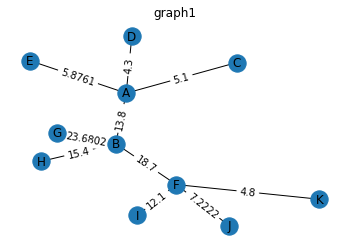

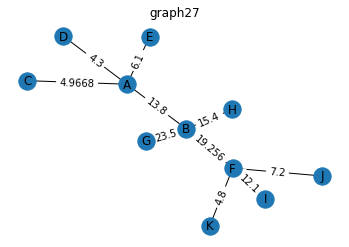

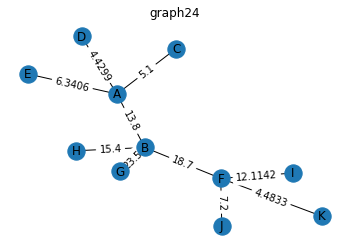

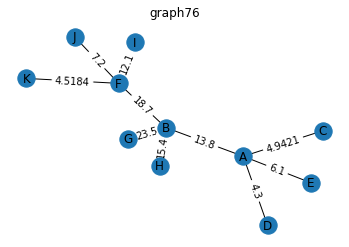

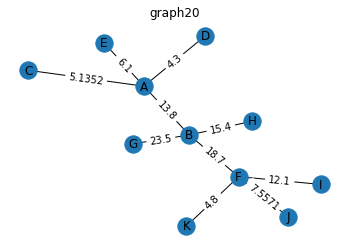

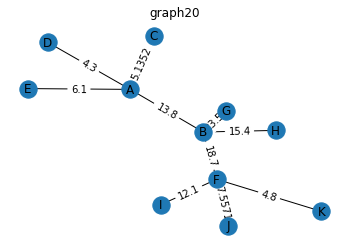

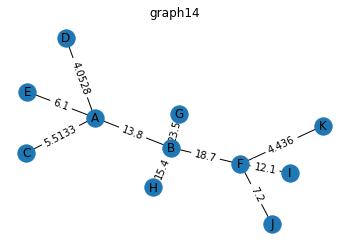

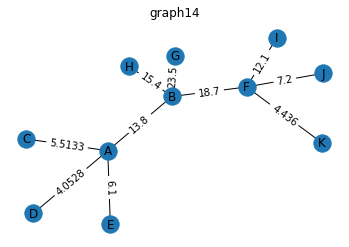

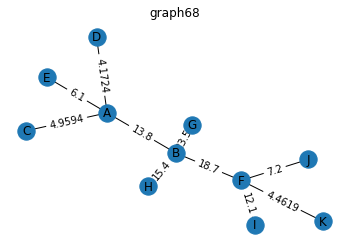

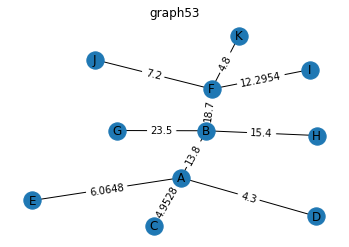

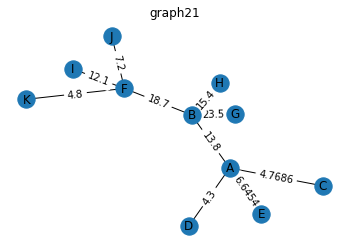

In [74]:
print("cos mode")
draw(top10_mode_cos, names_mode_cos, '', False)

cos except min max


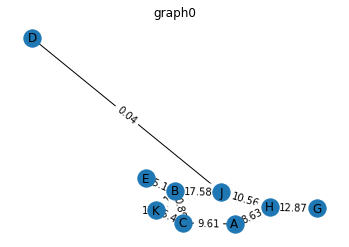

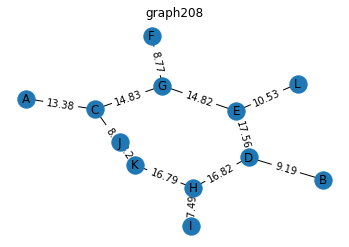

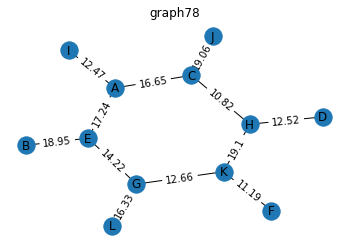

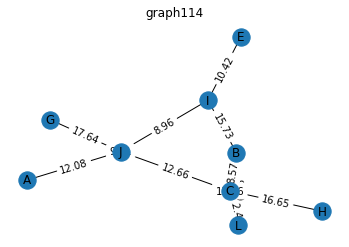

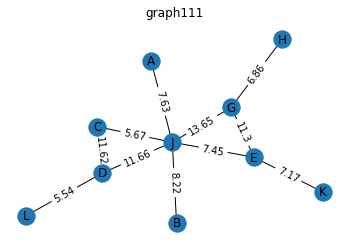

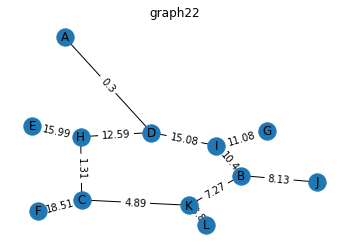

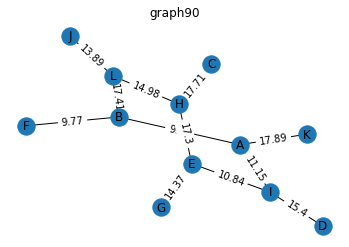

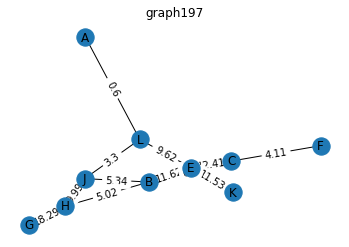

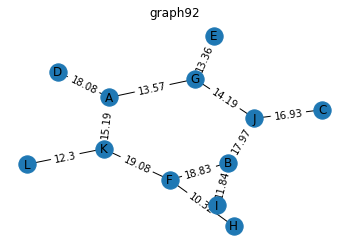

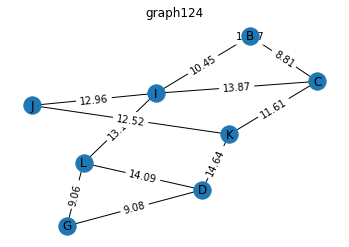

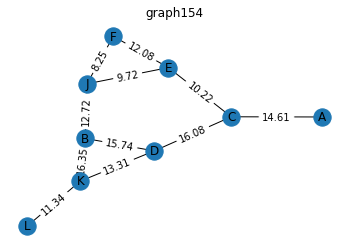

In [83]:
print("cos except min max")
draw(top10_except_cos, names_except_cos, '', False)

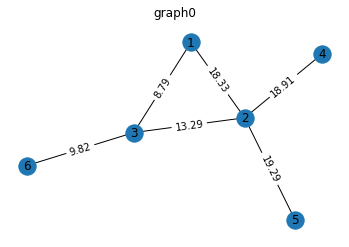

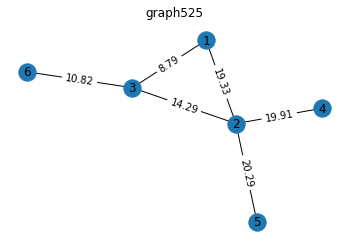

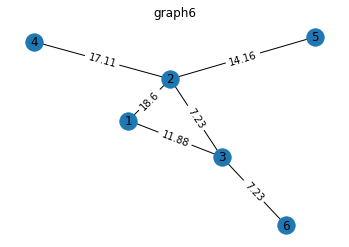

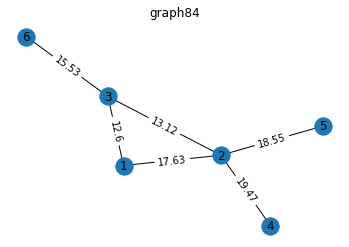

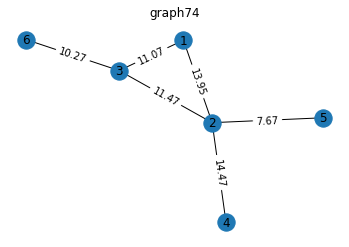

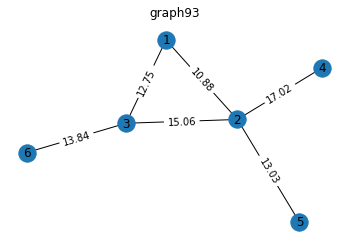

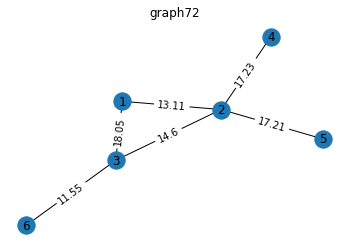

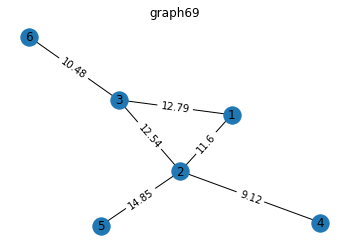

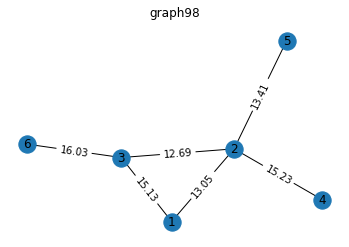

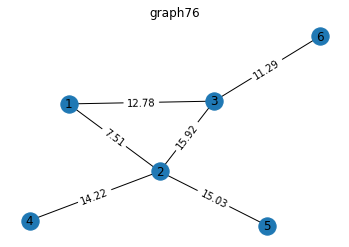

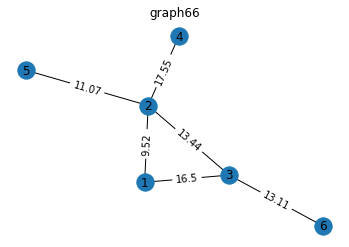

In [30]:
draw(top10_sum_cos, names_sum_cos, '', False)

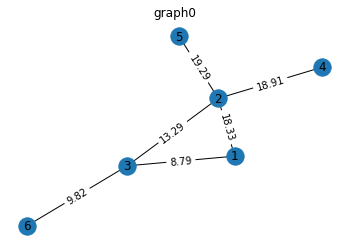

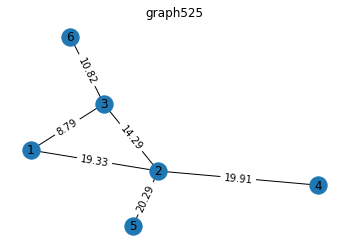

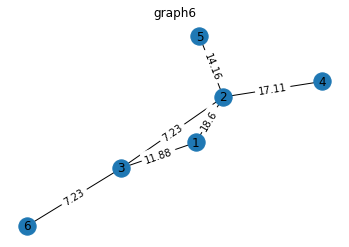

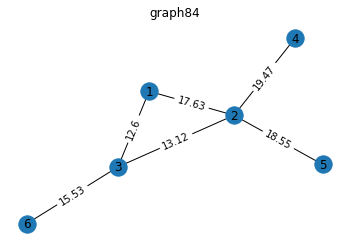

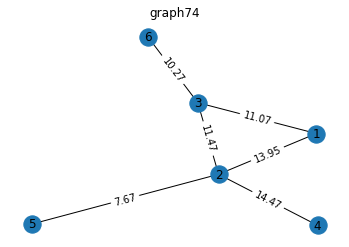

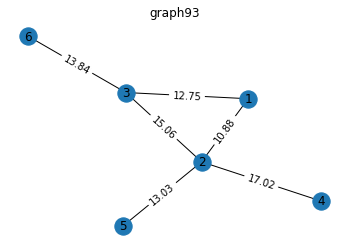

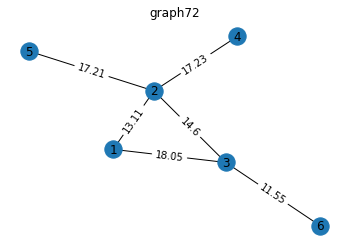

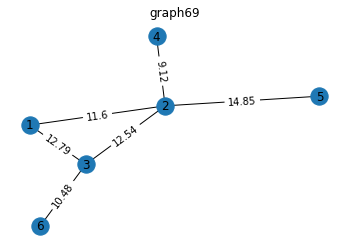

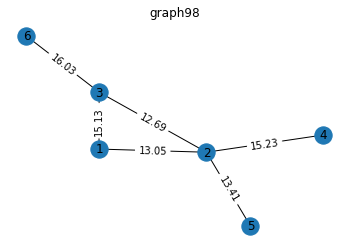

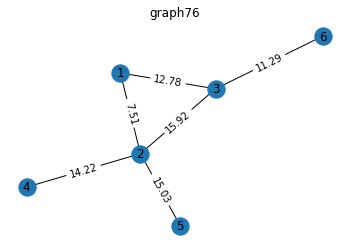

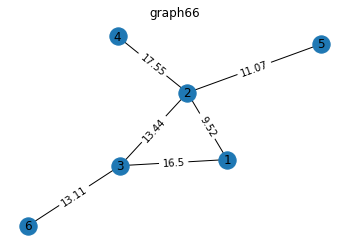

In [31]:
draw(top10_avg_cos, names_avg_cos, '', False)

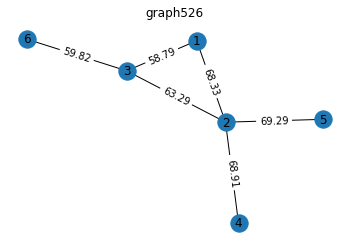

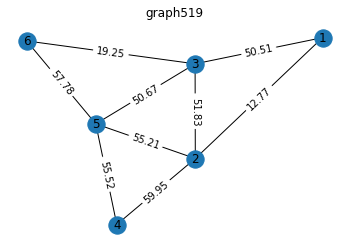

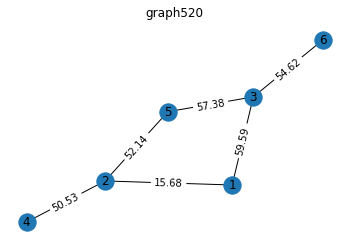

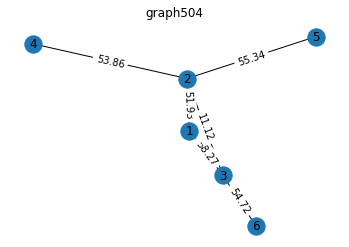

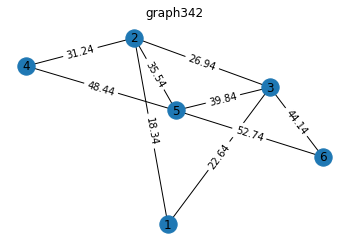

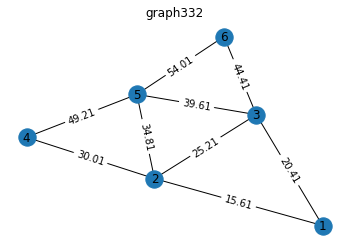

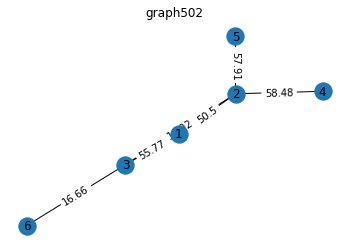

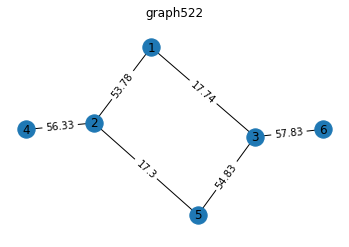

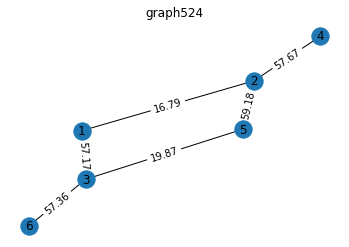

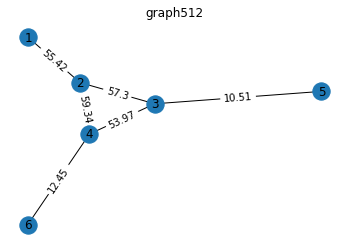

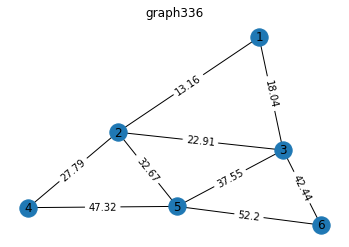

In [32]:
draw(back10_except_cos, names_except_cos[::-1], '', False)

In [449]:
result = np.array(except_embedding).reshape(600, 64)

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 600 samples in 0.001s...
[t-SNE] Computed neighbors for 600 samples in 0.010s...
[t-SNE] Computed conditional probabilities for sample 600 / 600
[t-SNE] Mean sigma: 0.017357
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.794632
[t-SNE] KL divergence after 1000 iterations: 0.322257


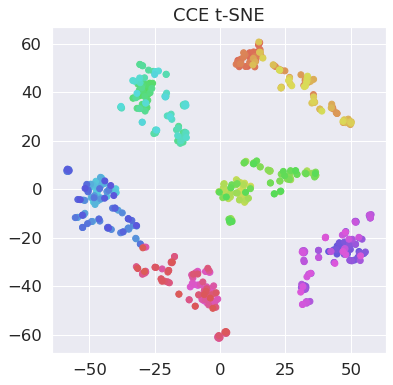

In [342]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
labels = [str(i) for i in range(len(result))]
tsne_train_xs = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=1000).fit_transform(result, labels)
plt.figure(figsize=(6, 6))
plt.scatter(x = tsne_train_xs[:,0], y=tsne_train_xs[:,1], color=sns.color_palette("hls", len(result)))


#for i in [0, 501, 525, 526]:
#    plt.annotate(str(i), (tsne_train_xs[i, 0], tsne_train_xs[i, 1]))

plt.title("CCE t-SNE")
plt.show()